In [21]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime
import pandas as pd
from glob import glob

In [22]:
# import zipfile

# #** unzip the folder GLEM_daily_dataset.zip **
# with zipfile.ZipFile("GLEM_daily_dataset.zip", "r") as zip_ref:
#     zip_ref.extractall("GLEM_daily_dataset")

# #** unzip the folder MADIA_daily_dataset_v1.3.zip **
# with zipfile.ZipFile("MADIA_daily_dataset_v1.3.zip", "r") as zip_ref:
#     zip_ref.extractall("MADIA_daily_dataset_v1.3")

In [23]:
#** load the dataframe of climatological variables **

# load data from the csv files
csv_files = sorted(glob("./MADIA_daily_dataset_v1.3/csv_data/*_e5_d.csv"))
csv_files = [file for file in csv_files if 1991 <= int(file.split('/')[-1].split('_')[0]) <= 1992]

dailyClimatological_data = pd.DataFrame()

for file in csv_files:
    df = pd.read_csv(file)

    # keep only the data that are referred to the Piedmont region
    df_piedmont = df[df['latitude'].between(44.0, 46.5) & df['longitude'].between(6.5, 9.0)]
    
    global_dailyClimatological_data = pd.concat([dailyClimatological_data, df], ignore_index=True)
    dailyClimatological_data = pd.concat([dailyClimatological_data, df_piedmont], ignore_index=True)

print(dailyClimatological_data.head())

# tasmin    mean of daily minimum near-surface air temperature
# tasmean   mean of daily average near-surface air temperature
# tasmax    mean of daily maximum near-surface air temperature
# rhmin     mean of daily minimum near-surface relative air humidity
# rhmax     mean of daily maximum near-surface relative air humidity
# ws10      mean of daily wind speed
# ssrd      mean of daily surface solar radiation downwards (shortwave radiation)
# ppn       sum of daily depth of water-equivalent precipitation
# pev       sum of daily crop reference evapotranspiration estimated by FAO Penman-Monteith method
# zg        geopotential height: average cell height (metres) above the geoid, which corresponds approximately to the elevation
# dekad     number of dekad from the beginning of the year
# expver    code which identiﬁes temporary data when expver=5
# mask      boolean code to identify cells belonging to the Italian country

   longitude  latitude        time    tasmin    tasmax   tasmean     rhmin  \
0       7.25      44.0  1991-01-01 -2.247864  5.563782  1.657959  0.592831   
1       7.25      44.0  1991-01-02 -3.348724  3.856262  0.253769  0.444172   
2       7.25      44.0  1991-01-03 -0.891388  7.161102  3.134857  0.650528   
3       7.25      44.0  1991-01-04  0.054962  3.950562  2.002762  0.706066   
4       7.25      44.0  1991-01-05 -5.585663  4.696960 -0.444351  0.307958   

      rhmax      ws10      ssrd       ppn       pev  expver  mask  
0  0.936595  1.581366  7.215224  0.002508  0.417441     1.0   1.0  
1  0.850283  1.228787  6.347265  0.000000  0.463205     1.0   1.0  
2  0.866600  0.860398  6.891922  0.015718  0.322711     1.0   1.0  
3  0.879245  1.040755  5.009695  0.082887  0.377663     1.0   1.0  
4  0.872699  1.498034  7.351231  0.000000  0.599895     1.0   1.0  


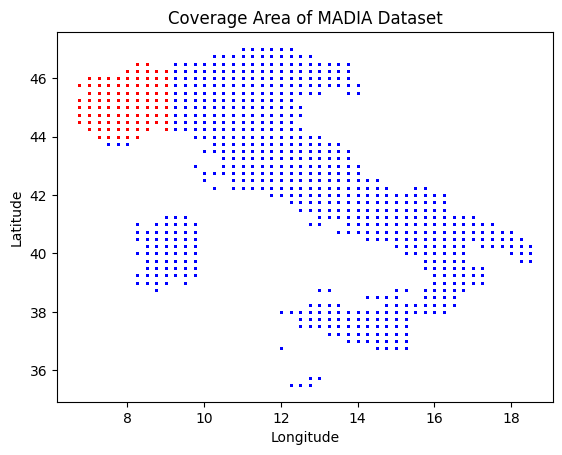

In [24]:
# **show a plot of the coverage area of the MADIA dataset**
# color in red the area of the Piedmont region

plt.scatter(global_dailyClimatological_data['longitude'], global_dailyClimatological_data['latitude'], s=1, c='blue', alpha=0.5)
plt.scatter(dailyClimatological_data['longitude'], dailyClimatological_data['latitude'], s=1, c='red', alpha=0.5)
plt.title('Coverage Area of MADIA Dataset')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [25]:
#** load the dataset of Evapotranspiration from the nc file
nc_files = sorted(glob("./GLEM_daily_dataset/E_*_GLEAM_v4.2a.nc"))

dailyE_data = []

for file in nc_files:
    ds = xr.open_dataset(file)

    # the evapotranspiration data are referenced to the Global territory
    E_lon = ds['lon'].values
    E_lat = ds['lat'].values

    # the climatological data are referenced to the Italian territory
    clim_lon = dailyClimatological_data['longitude'].values
    clim_lat = dailyClimatological_data['latitude'].values

    # select the evapotranspiration data for the Italian territory
    E_lon_idx = np.where((E_lon >= clim_lon.min()) & (E_lon <= clim_lon.max()))
    E_lat_idx = np.where((E_lat >= clim_lat.min()) & (E_lat <= clim_lat.max()))
    E_lon = E_lon[E_lon_idx]
    E_lat = E_lat[E_lat_idx]

    E_data = ds['E'].sel(lon=E_lon, lat=E_lat)
    dailyE_data.append(E_data)

dailyE_data = xr.concat(dailyE_data, dim='time')

/tmp/ipykernel_38034/3907745109.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis').copy()    # create a copy of the colormap


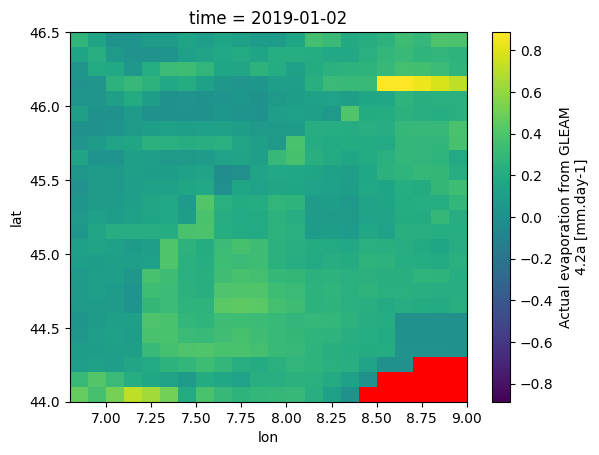

Daily Evapotranspiration shape (time, latitude, longitude): (1826, 25, 22)
Number of NaN values in the dataset: 14


In [26]:
#** show a plot of the Evapotranspiration data **
et = dailyE_data.isel(time=1)

cmap = cm.get_cmap('viridis').copy()    # create a copy of the colormap
cmap.set_bad(color='red')  # highlight NaN values in red

et.plot(cmap=cmap)  # plot the data with the modified colormap

plt.show()

print(f"Daily Evapotranspiration shape (time, latitude, longitude): {dailyE_data.shape}")

# count the number of pixel that are NaN at any time
nan_pixels = np.isnan(dailyE_data).any(dim='time').sum().item()
print(f"Number of NaN values in the dataset: {nan_pixels}")

In [27]:
#** evaluate the elapsed_days **
dailyClimatological_data['time'] = pd.to_datetime(dailyClimatological_data['time'])
dailyClimatological_data['elapsed_days'] = (dailyClimatological_data['time'] - dailyClimatological_data['time'].min()).dt.days.values
dailyClimatological_data['day_of_year'] = dailyClimatological_data['time'].dt.dayofyear.values

print(dailyClimatological_data.head())
print(dailyClimatological_data.tail())

   longitude  latitude       time    tasmin    tasmax   tasmean     rhmin  \
0       7.25      44.0 1991-01-01 -2.247864  5.563782  1.657959  0.592831   
1       7.25      44.0 1991-01-02 -3.348724  3.856262  0.253769  0.444172   
2       7.25      44.0 1991-01-03 -0.891388  7.161102  3.134857  0.650528   
3       7.25      44.0 1991-01-04  0.054962  3.950562  2.002762  0.706066   
4       7.25      44.0 1991-01-05 -5.585663  4.696960 -0.444351  0.307958   

      rhmax      ws10      ssrd       ppn       pev  expver  mask  \
0  0.936595  1.581366  7.215224  0.002508  0.417441     1.0   1.0   
1  0.850283  1.228787  6.347265  0.000000  0.463205     1.0   1.0   
2  0.866600  0.860398  6.891922  0.015718  0.322711     1.0   1.0   
3  0.879245  1.040755  5.009695  0.082887  0.377663     1.0   1.0   
4  0.872699  1.498034  7.351231  0.000000  0.599895     1.0   1.0   

   elapsed_days  day_of_year  
0             0            1  
1             1            2  
2             2            3 

In [28]:
#** associate the Evapotranspiration data to the climatological data **

# build a 2D grid of lat/lon points with the evapotranspiration data
grid_lat = dailyE_data['lat'].values
grid_lon = dailyE_data['lon'].values
grid_lon2d, grid_lat2d = np.meshgrid(grid_lon, grid_lat)

from scipy.spatial import cKDTree

# build a KDTree for fast nearest-neighbor search
grid_points = np.column_stack([grid_lat2d.ravel(), grid_lon2d.ravel()])
tree = cKDTree(grid_points)

# extract (lat, lon) from the climate data
query_points = dailyClimatological_data[['latitude', 'longitude']].values

# query the nearest grid points once
distances, indices = tree.query(query_points)

# convert flat indices to 2D (lat_idx, lon_idx)
lat_idx, lon_idx = np.unravel_index(indices, grid_lat2d.shape)

# time indices, evaluate the amount of days elapsed since the first day of the dataset
time_idx = dailyClimatological_data['elapsed_days']

# get values from xarray using vectorized indexing
E_values = dailyE_data.isel(
    time=xr.DataArray(time_idx, dims='points'),
    lat=xr.DataArray(lat_idx, dims='points'),
    lon=xr.DataArray(lon_idx, dims='points')
).values

# Assign to DataFrame
dailyClimatological_data['E'] = E_values

print(dailyClimatological_data.head())
print(dailyClimatological_data.tail())

print(f"Correction (degrees) - mean: {np.mean(distances):.6f}, min: {np.min(distances):.6f}, max: {np.max(distances):.6f}")

   longitude  latitude       time    tasmin    tasmax   tasmean     rhmin  \
0       7.25      44.0 1991-01-01 -2.247864  5.563782  1.657959  0.592831   
1       7.25      44.0 1991-01-02 -3.348724  3.856262  0.253769  0.444172   
2       7.25      44.0 1991-01-03 -0.891388  7.161102  3.134857  0.650528   
3       7.25      44.0 1991-01-04  0.054962  3.950562  2.002762  0.706066   
4       7.25      44.0 1991-01-05 -5.585663  4.696960 -0.444351  0.307958   

      rhmax      ws10      ssrd       ppn       pev  expver  mask  \
0  0.936595  1.581366  7.215224  0.002508  0.417441     1.0   1.0   
1  0.850283  1.228787  6.347265  0.000000  0.463205     1.0   1.0   
2  0.866600  0.860398  6.891922  0.015718  0.322711     1.0   1.0   
3  0.879245  1.040755  5.009695  0.082887  0.377663     1.0   1.0   
4  0.872699  1.498034  7.351231  0.000000  0.599895     1.0   1.0   

   elapsed_days  day_of_year         E  
0             0            1  0.182108  
1             1            2  0.642770  

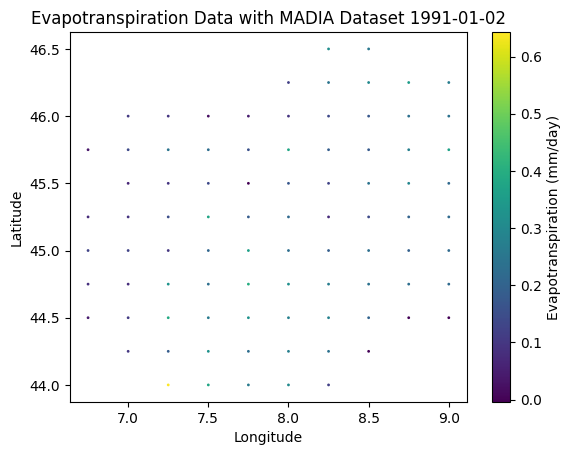

In [29]:
#** show a plot of the Evapotranspiration data with the MADIA dataset **
et = dailyClimatological_data[dailyClimatological_data['elapsed_days'] == 1]
plt.scatter(et['longitude'], et['latitude'], s=1, c=et['E'], cmap='viridis')
plt.colorbar(label='Evapotranspiration (mm/day)')
plt.title(f'Evapotranspiration Data with MADIA Dataset {et["time"].dt.strftime("%Y-%m-%d").values[0]}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [30]:
#** drop the rows with NaN values in the Evapotranspiration column **
print(f"Number of rows before dropping NaN values: {len(dailyClimatological_data)}")
dailyClimatological_data = dailyClimatological_data.dropna(subset=['E'])
print(f"Number of rows after dropping NaN values: {len(dailyClimatological_data)}")

Number of rows before dropping NaN values: 64328
Number of rows after dropping NaN values: 63597


In [31]:
#** print the fields of the dataframe **
print(dailyClimatological_data.columns)

Index(['longitude', 'latitude', 'time', 'tasmin', 'tasmax', 'tasmean', 'rhmin',
       'rhmax', 'ws10', 'ssrd', 'ppn', 'pev', 'expver', 'mask', 'elapsed_days',
       'day_of_year', 'E'],
      dtype='object')


In [32]:
#** apply normalization to the features **
from sklearn.preprocessing import MinMaxScaler

# normilize the features
features = ['day_of_year', 'tasmin', 'tasmean', 'tasmax', 'rhmin', 'rhmax', 'ws10', 'ssrd', 'ppn']
featureScaler = MinMaxScaler()
dailyClimatological_data[features] = featureScaler.fit_transform(dailyClimatological_data[features])

# normilize the target
target = 'E'
targetScaler = MinMaxScaler()
dailyClimatological_data[target] = targetScaler.fit_transform(dailyClimatological_data[[target]])

print(dailyClimatological_data.head())

   longitude  latitude       time    tasmin    tasmax   tasmean     rhmin  \
0       7.25      44.0 1991-01-01  0.498115  0.456594  0.482039  0.572352   
1       7.25      44.0 1991-01-02  0.478368  0.427120  0.456898  0.415352   
2       7.25      44.0 1991-01-03  0.522447  0.484165  0.508482  0.633286   
3       7.25      44.0 1991-01-04  0.539423  0.428748  0.488213  0.691939   
4       7.25      44.0 1991-01-05  0.438243  0.441632  0.444398  0.271497   

      rhmax      ws10      ssrd       ppn       pev  expver  mask  \
0  0.921581  0.110296  0.215258  0.000016  0.417441     1.0   1.0   
1  0.815228  0.083021  0.187665  0.000000  0.463205     1.0   1.0   
2  0.835333  0.054523  0.204980  0.000103  0.322711     1.0   1.0   
3  0.850914  0.068475  0.145143  0.000542  0.377663     1.0   1.0   
4  0.842849  0.103849  0.219582  0.000000  0.599895     1.0   1.0   

   elapsed_days  day_of_year         E  
0             0     0.000000  0.043149  
1             1     0.002740  0.129007  

In [33]:
#** select random samples from the dataset **
 
# select half of the unique points in the dataset
n_samples = int(len(np.unique(dailyClimatological_data[['longitude', 'latitude']])) / 2)
unique_locations = dailyClimatological_data[['longitude', 'latitude']].drop_duplicates()

# sample n_samples unique locations
sampled_locations = unique_locations.sample(n=n_samples, random_state=42)

X_sequences = []
y_sequences = []

sequence_length = 30

for _, loc in sampled_locations.iterrows():
    loc_data = dailyClimatological_data[
        (dailyClimatological_data['longitude'] == loc['longitude']) &
        (dailyClimatological_data['latitude'] == loc['latitude'])
    ].sort_values(by='elapsed_days')

    features = loc_data[['day_of_year', 'tasmin', 'tasmean', 'tasmax', 'rhmin', 'rhmax', 'ws10', 'ssrd', 'ppn']].values
    target = loc_data['E'].values
        
    for i in range(len(loc_data) - sequence_length):
        X_seq = features[i:i+sequence_length]
        y_val = target[i+sequence_length]
        X_sequences.append(X_seq)
        y_sequences.append(y_val)

X = np.array(X_sequences)
y = np.array(y_sequences)

In [34]:
#** build a dataset of shape (n_samples, n_features) **
print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(X[0][:5])
print(y[0])

Feature matrix shape: (7010, 30, 9)
Target vector shape: (7010,)
[[0.00000000e+00 4.38976240e-01 3.99871814e-01 3.55073876e-01
  5.35220679e-01 7.48862641e-01 1.42518520e-01 1.63447702e-01
  8.37924573e-04]
 [2.73972603e-03 4.17313888e-01 3.83812761e-01 3.44955291e-01
  7.27424028e-01 8.13240839e-01 1.00821348e-01 1.12154049e-01
  1.78187119e-02]
 [5.47945205e-03 5.16741074e-01 4.58097594e-01 3.92508795e-01
  6.15040616e-01 7.92476006e-01 8.95762143e-02 1.83570642e-01
  3.49052478e-04]
 [8.21917808e-03 4.91267613e-01 4.32834112e-01 3.68310369e-01
  7.07170808e-01 8.61935295e-01 5.41307808e-02 7.00210763e-02
  6.68076217e-02]
 [1.09589041e-02 4.16682175e-01 3.86619905e-01 3.50975662e-01
  4.53395045e-01 7.61748197e-01 1.21429120e-01 2.06945495e-01
  1.30285477e-03]]
0.073883764


In [35]:
#** mix the sequences of data **
from sklearn.utils import shuffle

X, y = shuffle(X, y, random_state=42)

print(f"Feature matrix shape after shuffle: {X.shape}")
print(f"Target vector shape after shuffle: {y.shape}")
print(X[0][:5])
print(y[0])

Feature matrix shape after shuffle: (7010, 30, 9)
Target vector shape after shuffle: (7010,)
[[4.82191781e-01 7.71422031e-01 7.72612256e-01 7.53855887e-01
  6.26858856e-01 9.45970729e-01 5.39435865e-02 6.86132495e-01
  1.93920879e-02]
 [4.84931507e-01 8.20493509e-01 7.85300837e-01 7.31100814e-01
  6.60546730e-01 9.29692332e-01 6.25939608e-02 6.06041176e-01
  1.56564096e-02]
 [4.87671233e-01 8.18239795e-01 8.02212541e-01 7.65877162e-01
  6.06979151e-01 9.25078191e-01 7.53179759e-02 6.73476952e-01
  1.46061137e-02]
 [4.90410959e-01 8.23034066e-01 7.94176058e-01 7.45768523e-01
  5.09607258e-01 8.48999420e-01 1.03396006e-01 6.17521752e-01
  6.67408848e-03]
 [4.93150685e-01 8.22499234e-01 8.04748127e-01 7.66667300e-01
  4.26891136e-01 8.12519107e-01 8.69677043e-02 7.14832113e-01
  2.50630043e-04]]
0.62130296


In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (5608, 30, 9), (5608,)
Testing set shape: (1402, 30, 9), (1402,)


In [37]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

# the model learns to predict the next day ET value based on the previous 30 days of data

model = tf.keras.Sequential()

model.add(tf.keras.layers.Input(shape=(sequence_length, 9)))  # input shape (sequence_length, n_features)
model.add(tf.keras.layers.LSTM(128, return_sequences=True))   # return_sequences=True, each of the LSTM cells returns its sequence of 128 outputs. So the output shape is (batch_size, sequence_length, 128)
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization()) # normalization is applied to the output of the LSTM layer

model.add(tf.keras.layers.LSTM(64, return_sequences=False)) # return_sequences=False, the last LSTM cell returns its last output. So the output shape is (batch_size, 64)
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization()) # normalization is applied to the output of the LSTM layer

model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(1))  # predict a single ET value

model.compile(optimizer='adam', loss='mse')
model.summary()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 128)        │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 30, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,057 (488.50 KB)

 Trainable params: 124,673 (487.00 KB)

 Non-trainable params: 384 (1.50 KB)

In [38]:
# i am feeding the NN with 32 sequences at a time (batch size). Each of these sequences is made by 30 days of data, each data is made by 8 features
# I have 7010 * 0.8 due to train and test set split, these sequences are divided in batches of 32 and with a validation split of 0.2, means that the number of iterations needed to complete each epoch is 7010 * 0.8 * 0.8 / 32 = 140.2
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.4748 - val_loss: 0.0398
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0931 - val_loss: 0.0283
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0507 - val_loss: 0.0134
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0374 - val_loss: 0.0102
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0278 - val_loss: 0.0123
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0229 - val_loss: 0.0106
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0203 - val_loss: 0.0098
Epoch 8/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0176 - val_loss: 0.0093
Epoch 9/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0155 - val_loss: 0.0089
Epoch 10/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0139 - val_loss: 0.0133
Epoch 11/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0147 - val_loss: 0.0095
Epoch 12/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 

In [39]:
#** test the model on the test set **
y_pred = model.predict(X_test)

# invert the normalization of the predicted values
y_pred_rescaled = targetScaler.inverse_transform(y_pred)
y_test_rescaled = targetScaler.inverse_transform(y_test.reshape(-1, 1))

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


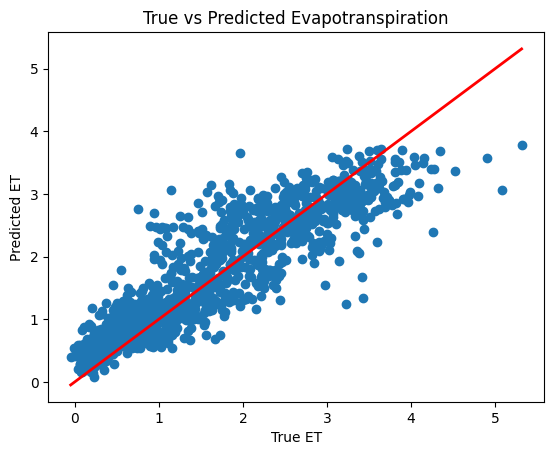

In [40]:
#**  see a plot of the accuracy of the predictions **
plt.scatter(y_test_rescaled, y_pred_rescaled)
plt.plot([min(y_test_rescaled), max(y_test_rescaled)], [min(y_test_rescaled), max(y_test_rescaled)], color='red', lw=2)  # Identity line
plt.xlabel('True ET')
plt.ylabel('Predicted ET')
plt.title('True vs Predicted Evapotranspiration')
plt.show()